In [3]:
from typing import Dict, Text

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dropout, Lambda, BatchNormalization
import matplotlib.pyplot as plt

2022-06-12 12:56:30.066773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-12 12:56:30.066838: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**FIX CODE**

In [4]:
# Read the data
df = pd.read_csv('/home/harisyf/Documents/Bangkit 2022/Capstone Project/Dataset_Refield.csv')
# Get take the columns we need for training
rating_data = df[["User_ID","Field_ID", "User_Rating","Field_Name"]]
dataset = tf.data.Dataset.from_tensor_slices((tf.cast(rating_data['User_ID'].values.reshape(-1,1), tf.int32), 
                                              tf.cast(rating_data['Field_ID'].values.reshape(-1,1), tf.int32), 
                                              tf.cast(rating_data['User_Rating'].values.reshape(-1,1),tf.float32),
                                              tf.cast(rating_data['Field_Name'].values.reshape(-1,1), tf.string)))

2022-06-12 12:57:31.616982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-12 12:57:31.617052: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-12 12:57:31.617117: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (harisyf-MS-7C89): /proc/driver/nvidia/version does not exist
2022-06-12 12:57:31.645125: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.int32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.string, name=None))>

In [5]:
field = rating_data.Field_ID.values
users = rating_data.User_ID.values
name = rating_data.Field_Name.values

unique_field_id = np.unique(list(field))
unique_user_ids = np.unique(list(users))
unique_field_name = np.unique(list(name))

In [4]:
unique_field_name

array(['AS FUTSAL', 'Centro Futsal', 'Champion Futsal',
       'Cililitan Badminton Hall', 'Diaz Badminton Hall',
       'Futsal Court Cilandak Sport Centre', 'Futsal Sani',
       'GOR Badminton Mega Kuningan', 'GOR Kurnia Badminton Court',
       'Gedung Bulutangkis Gelora Sunter', 'Go All Futsal',
       'Kuningan Village Futsal Field 1', 'Lapangan Badminton Tomang',
       'Lapangan Bulu Tangkis Patra', 'Lapangan Bulutangkis Talenta',
       'Pelangi Futsal', 'Planet Futsal', 'Royal Futsal',
       'Supreme Arena Badminton', 'Tunas Bugar Badminton Hall'],
      dtype='<U34')

In [6]:
def rename(x0,x1,x2,x3):
    y = {}
    y["User_ID"] = x0
    y['Field_ID'] = x1
    y['User_Rating'] = x2
    y['Field_Name'] = x3
    return y

dataset = dataset.map(rename)

In [7]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.IntegerLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for field.
    self.field_embeddings = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_field_name, mask_token=None),
      tf.keras.layers.Embedding(len(unique_field_name) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def __call__(self, x):
   
    User_ID, Field_Name = x
    user_embedding = self.user_embeddings(User_ID)
    field_embedding = self.field_embeddings(Field_Name)

    return self.ratings(tf.concat([user_embedding, field_embedding], axis=1))

In [8]:
class FieldModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def compute_loss(self, features, training=False) -> tf.Tensor:
    print(features)
    rating_predictions = self.ranking_model((features['User_ID'], features["Field_Name"]))

    # The task computes the loss and the metrics.
    return self.task(labels=features["User_Rating"], predictions=rating_predictions)

In [9]:
tf.random.set_seed(42)
shuffled = dataset.shuffle(8902, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(7122)
test = shuffled.skip(7122).take(1780)

In [10]:
model = FieldModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.4))

# Training 
history = model.fit(train, validation_data = test, epochs=15)


Epoch 1/15
{'User_ID': <tf.Tensor 'IteratorGetNext:2' shape=(1,) dtype=int32>, 'Field_ID': <tf.Tensor 'IteratorGetNext:0' shape=(1,) dtype=int32>, 'User_Rating': <tf.Tensor 'IteratorGetNext:3' shape=(1,) dtype=float32>, 'Field_Name': <tf.Tensor 'IteratorGetNext:1' shape=(1,) dtype=string>}
{'User_ID': <tf.Tensor 'IteratorGetNext:2' shape=(1,) dtype=int32>, 'Field_ID': <tf.Tensor 'IteratorGetNext:0' shape=(1,) dtype=int32>, 'User_Rating': <tf.Tensor 'IteratorGetNext:3' shape=(1,) dtype=float32>, 'Field_Name': <tf.Tensor 'IteratorGetNext:1' shape=(1,) dtype=string>}
7122/7122 [==============================] - 10s 774us/step - root_mean_squared_error: 2.4548 - loss: 6.0254 - regularization_loss: 0.0000e+00 - total_loss: 6.0254 - val_root_mean_squared_error: 0.9819 - val_loss: 0.1815 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.1815
Epoch 2/15
7122/7122 [==============================] - 5s 760us/step - root_mean_squared_error: 0.5806 - loss: 0.3370 - regularization_loss: 0.0

In [27]:
print(history.history.keys())

dict_keys(['root_mean_squared_error', 'loss', 'regularization_loss', 'total_loss', 'val_root_mean_squared_error', 'val_loss', 'val_regularization_loss', 'val_total_loss'])


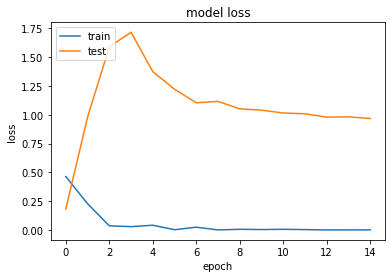

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
# Create array with users id in every place on the lenght of the unique books number
id_ = input('Enter the user_id: ')
user = np.array([id_ for i in range(len(unique_field_id))])
vector = np.vectorize(np.int32)
user = vector(user)
# Convert it to tf.data.Dataset 
test_data = tf.data.Dataset.from_tensor_slices((tf.cast(user.reshape(-1,1), tf.int32), 
                                                tf.cast(unique_field_name.reshape(-1,1), tf.string)))
# Name the columns 
def rename_test(x0,x1):
    y = {}
    y["User_ID"] = x0
    y['Field_Name'] = x1
    return y
test_data = test_data.map(rename_test)

# Now lets make predictions and store them in to dictionary
test_ratings = {}
for b in test_data:
    test_ratings[b['Field_Name'].numpy()[0]] = model.ranking_model((b['User_ID'],b['Field_Name']))

# sort them by score and print the titles 
for b in sorted(test_ratings, key=test_ratings.get):
    print(b.decode('utf-8'))

Royal Futsal
GOR Kurnia Badminton Court
Pelangi Futsal
AS FUTSAL
Cililitan Badminton Hall
Centro Futsal
Futsal Sani
Kuningan Village Futsal Field 1
GOR Badminton Mega Kuningan
Go All Futsal
Planet Futsal
Tunas Bugar Badminton Hall
Diaz Badminton Hall
Lapangan Bulu Tangkis Patra
Lapangan Bulutangkis Talenta
Supreme Arena Badminton
Lapangan Badminton Tomang
Gedung Bulutangkis Gelora Sunter
Futsal Court Cilandak Sport Centre
Champion Futsal


In [ ]:
model.save_weights('/content')

In [12]:
refield_model = "refield-model"

In [13]:
tf.saved_model.save(model,refield_model)

2022-06-12 13:00:06.283615: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: refield-model/assets


INFO:tensorflow:Assets written to: refield-model/assets


In [18]:
imported = tf.saved_model.load(refield_model)
print(imported.signatures)

_SignatureMap({})


In [19]:
converter = tf.lite.TFLiteConverter.from_saved_model(refield_model,signature_keys=[])
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]


ValueError: Only support at least one signature key.

In [ ]:
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(refield_model) # path to the SavedModel directory
tflite_model = converter.convert()

ValueError: ignored

In [ ]:
tf.saved_model.save(model, refield_model,
                    signatures={
                        'RankingModel': model.RankingModel.get_concrete_function(),
                        'FieldModel': model.FieldModel.get_concrete_function()
                        })

INFO:tensorflow:Assets written to: refield-model/assets


INFO:tensorflow:Assets written to: refield-model/assets


In [ ]:
%%bash -s $refield_model
tflite_convert \
         --output_file=/content/foo.tflite \
         --saved_model_dir=/content/refield-model \
         --saved_model_signature_key=''

2022-06-11 09:55:31.476740: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Traceback (most recent call last):
  File "/usr/local/bin/tflite_convert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/tflite_convert.py", line 693, in main
    app.run(main=run_main, argv=sys.argv[:1])
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/tflite_convert.py", line 676, in run_main
    _convert_tf2_model(tflite_flags)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/tflite_convert.py", line 280, in _convert_tf2_model
    tags=_parse_set(flags.saved_model_tag_set))
  File "/usr/local/lib/python3.7/dis

In [ ]:
loaded = tf.saved_model.load(refield_model)

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

#export using tflite
converter = tf.lite.TFLiteConverter.from_saved_model(refield_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

[]


KeyError: ignored

In [ ]:
loaded = tf.saved_model.load(refield_model)

# Convert the saved model using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_saved_model(refield_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Print the signatures from the converted model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
signatures = interpreter.get_signature_list()
print(signatures)

ValueError: ignored